# Q4 Computational Problem: Synthetic Data

In this problem, we will fit penalized logistic regression models for simple 2D synthetic datasets.

## Helper Code

In [17]:
import matplotlib.pyplot as plt
from sklearn import datasets
import cvxpy as cp
import numpy as np
from scipy.special import expit as inverse_logit

#### HELPER FUNCTIONS ####
def compute_log_loss(y_true, y_proba, eps=1e-15):
    """
    computes mean logistic loss using labels and probability predictions
    :param y_true: vector of true labels - y_true[i] in (-1,+1) and y_true[i] (0,1) are both OK
    :param y_proba: vector of predicted probabilities
    :param eps: minimum distance that y_pred must maintain from 0 and 1
    :return: log_loss
    """
    p = np.clip(y_proba, eps, 1.0 - eps)
    y = y_true > 0
    L = y * np.log(p) + (1 - y) * np.log(1.0 - p)
    return -np.mean(L)

def compute_auc(y_true, y_proba):
    """
    computes AUC for a binary classifier quickly
    :param y_true: vector of true classes
    :param y_proba: vector of predicted probabilities
    :return: auc
    """
    n = len(y_true)
    I_pos = y_true > 0
    # if y[i] == 0 for all i or y[i] == 1 for all i, then return AUC = 1
    if I_pos.all() or np.logical_not(I_pos).all():
        return float('nan')

    I_pos = I_pos[np.argsort(y_proba)]
    false_positive_count = np.cumsum(1 - I_pos)
    n_false = false_positive_count[-1]
    auc = np.multiply(I_pos, false_positive_count).sum() / (
            n_false * (n - n_false))
    return auc

def compute_ece(y_true, y_proba, n_bins=10):
    """
    computes expected calibration error for a binary classifier
    :param y_true: vector of true classes
    :param y_proba: vector of predicted probabilities
    :param n_bins: 10
    :return:ece
    """

    # pre-process to improve binning
    sort_idx = np.argsort(y_proba)
    y_pred = y_proba[sort_idx]
    y_true = y_true[sort_idx] > 0
    n = len(y_true)

    acc = np.zeros(n_bins)
    conf = np.zeros(n_bins)
    counts = np.zeros(n_bins)

    for k in range(n_bins):
        left_idx = np.searchsorted(y_pred, k / n_bins, side='left')
        right_idx = np.searchsorted(y_pred, (k + 1) / n_bins, side='right')
        if left_idx < right_idx:
            bin_idx = np.arange(left_idx, right_idx)
            counts[k] = len(bin_idx)
            conf[k] = np.mean(y_pred[bin_idx])
            acc[k] = np.mean(y_true[bin_idx])

    ece = np.sum(counts * np.abs(acc - conf)) / n
    return ece

def plot_data(X, y):
    pos_idx = np.greater(y, 0)
    neg_idx = ~pos_idx
    plt.plot(X[pos_idx, 0], X[pos_idx, 1], 'b.', markersize = 10, alpha = 0.3)
    plt.plot(X[neg_idx, 0], X[neg_idx, 1], 'r.',  markersize = 10,  alpha = 0.3)
    plt.show()


## Part (a)
Implement $L_2$-penalized logistic regression using `cvxpy`. We have provided you all other than the code for the `fit` method. For this quesiton, you will have to complete the implementation for `fit` starting from line 29. You only need to implement an optimization problem that can be solved to return the correct coefficients. We have already defined the variables and parameters, so all that you need to do is to define the correct objective function and create the optimization problem `cvxpy.` This should only require 2 lines of code.

In [18]:
class L2LogisticRegression(object):

    def __init__(self, C = 0.0):
        assert np.greater_equal(C, 0.0)
        self.C = cp.Parameter(nonneg=True)
        self.C.value = C

    # main methods
    def check_data(self, X, y):
        assert X.ndim == 2
        assert X.shape[0] > 0
        assert np.isfinite(X).all()
        assert np.isfinite(y).all()
        assert np.isin(y, (0, 1)).all()
        return True

    def fit(self, X, y):
        """
        :return: coefficients of optimal model
        """
        assert self.check_data(X, y)
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.X = X
        self.y = y
        self.w = cp.Variable(self.d)
        self.t = cp.Variable(1)

        ## YOUR CODE STARTS HERE

        y_transformed = 2 * y - 1
        logistic_loss = cp.sum(cp.logistic(-cp.multiply(y_transformed, X @ self.w + self.t))) / self.n
        l2_penalty = self.C * cp.norm(self.w, 2) ** 2
        objective = cp.Minimize(logistic_loss + l2_penalty)
        self.problem = cp.Problem(objective)
        self.problem.solve()

    #### Classifier Properties ###
    @property
    def has_solution(self):
        return self.w.value is not None

    @property
    def intercept(self):
        if self.has_solution:
            return self.t.value
        else:
            return np.nan

    @property
    def coefs(self):
        if self.has_solution:
            return self.w.value
        else:
            return np.repeat(np.nan, self.d)

    #### prediction API ####
    def decision_function(self, X):
        """
        returns confidence score
        :param X:
        :return: vector of confidence scores for each row in X
        """
        scores = X.dot(self.coefs) + self.intercept
        return scores

    def predict_proba(self, X):
        """
        predicts probability of positive class
        :param X: feature matrix with d columns features
        :return: vector of predicted probabilities for each row in X
        """
        scores = self.decision_function(X)
        probs = np.zeros_like(scores)
        pos_idx = np.greater_equal(scores, 0)
        neg_idx = np.logical_not(pos_idx)
        probs[pos_idx] = 1.0 / (1.0 + np.exp(-scores[pos_idx]))
        probs[neg_idx] = np.exp(scores[neg_idx]) / (1.0 + np.exp(scores[neg_idx]))
        return probs

    def predict(self, X):
        """
        predicts label for each row in X
        :param X: feature matrix with d columns features
        :return: vector of confidence scores for each row in X
        """
        probs = self.predict_proba(X)
        yhat = np.greater(probs, 0.5)
        return yhat

## Part (b)
Generate a dataset of $n = 1000$ points by calling the following function in the helper code

```X, y = generate_data_4b(n = 1000)```

b) Plot the positive and negative samples in your dataset using the `plot_data` function in the helper code. Use your plot to explain whether you expect this classification task to be *easy* or *hard*.

c) Set the penalty parameter of your model to fit a "vanilla" logistic regression model -- i.e., with no regularization. Report the values of the logistic loss, AUC, and ECE of your model on the training dataset. Write the score function of this model using the fitted values of `L2LogisticRegression.coefs` and `L2LogisticRegression.intercept`

d) plot a histogram of the probability predictions of the model from on the training dataset. Use these results to explain the behavior of logistic regression on this dataset. Why does `cvxpy` throw a warning in this case?

e) Fit a penalized logistic regression model on the same dataset where you set the $L_2$-penalty to $\lambda = 0.1$. How do your results from parts (ii) and (iii) change? Does `cvxpy` still throw a warning?

In [19]:
def generate_dataset_4b(n = 1000, seed = 42):
    assert n > 2
    n = int(n)
    separable = False
    while not separable:
        X, y = datasets.make_blobs(n_samples=n, centers=[(2.0, 2.0), (8.0, 8.0)], n_features=2, center_box=(0, 10), random_state = seed)
        red = X[y == 0]
        blue = X[y == 1]
        separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
    return X, y

# (b)

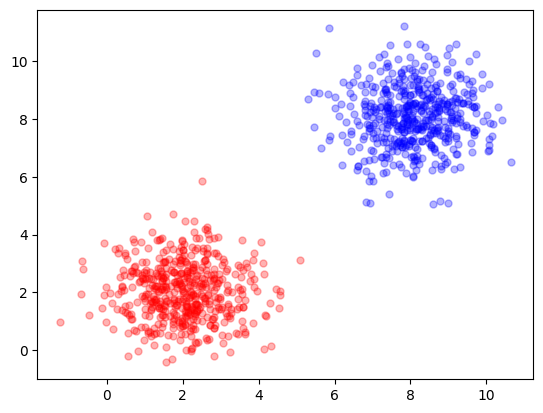

In [20]:

X, y = generate_dataset_4b(1000)
plot_data(X, y)

# (c)

In [21]:

model = L2LogisticRegression(C=0.0) # no regularization
model.fit(X, y)

y_proba = model.predict_proba(X)
log_loss = compute_log_loss(y, y_proba)
auc = compute_auc(y, y_proba)
ece = compute_ece(y, y_proba)

print(f"Logistic Loss: {log_loss}")
print(f"AUC: {auc}")
print(f"ECE: {ece}")
print(f"Score function: f(x) = {model.coefs} * x + {model.intercept}")

Logistic Loss: 2.9147959713793767e-06
AUC: 1.0
ECE: 2.9135694717983072e-06
Score function: f(x) = [4.39127801 3.38285942] * x + [-39.37343769]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# (d)

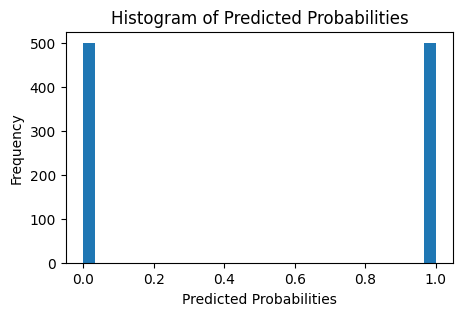

In [22]:
plt.figure(figsize=(5, 3))
plt.hist(y_proba, bins=30)
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()


Since the data is total linearly separated, the model will produce very large coeficients and assign predicted probabilities very close to 0 and 1. This extreme confidence leads to a peaked histogram around 0 and 1.

For the cvxpy warning, since there’s perfect separability, there’s no finite maximum likelihood solution for this unregularized logistic regression. So the optimization becomes ill-posed and throws warning.

# (e)

In [23]:

model_penalized = L2LogisticRegression(C=0.1)  # C = 1 / λ
model_penalized.fit(X, y)

y_proba_penalized = model_penalized.predict_proba(X)
log_loss_penalized = compute_log_loss(y, y_proba_penalized)
auc_penalized = compute_auc(y, y_proba_penalized)
ece_penalized = compute_ece(y, y_proba_penalized)

print(f"Penalized Logistic Loss: {log_loss_penalized}")
print(f"Penalized AUC: {auc_penalized}")
print(f"Penalized ECE: {ece_penalized}")

Penalized Logistic Loss: 0.045814754377215064
Penalized AUC: 1.0
Penalized ECE: 0.044058111169507225


Adding regularization will penalize the large weights, and give the optimization a unique finite solution. The warning will not be thrown any more.

AUC doesn't change, calibration (ECE) is bigger, and training loss increase slightly. Generalization may improve on noisy or real data.

## Part (c)
Generate a dataset of $n = 1000$ points by calling the function

```X, y = generate_data_4c(n = 1000)```

This function generates $n = 1000$ examples from the following distribution:

\begin{align*}
    x_1, x_2 &\sim \textsf{Normal}([5, 5], I)\\
    p &= \textrm{logistic}(10 -x_1 -x_2)\\
    y  &\sim \textsf{Bernoulli}(p)
\end{align*}

f) Plot the positive and negative samples in your dataset. Do you expect this classification task to be easier or harder in comparison from part (b)? Why or why not?

g) What are the coefficients that you should expect if you were to fit a logistic regression model on a very large number of samples on this dataset?

h) Fit a vanilla logistic regression model. How do the coefficients of the vanilla logistic regression model you fit compare to these value you stated in the previous part?

i) What is the value of your training loss, AUC, and ECE of your model. Explain how you expect each of these summary statistics to change as you fit a model using a very large number of samples on this dataset?

j) Would you expect to improve prediction accuracy on this dataset by fitting a penalized logistic regression model and tuning the $\ell_2$ penalty? Why or why not?

k) Would you expect to improve prediction accuracy on this dataset by fitting a model with basis functions for $x_1$ and $x_2$? Why or why not

In [24]:
def generate_dataset_4c(n = 100, std = 2.0,  seed = 1):
    assert n > 2
    n = int(n)
    X, _ = datasets.make_blobs(n_samples=n, centers = [(5, 5)], cluster_std = std,  n_features = 2, random_state = seed)
    scores = 10.0 - X[:, 0] - X[:, 1]
    p = inverse_logit(scores / std)
    y = np.random.binomial(1, p)
    return X, y

# c(f)

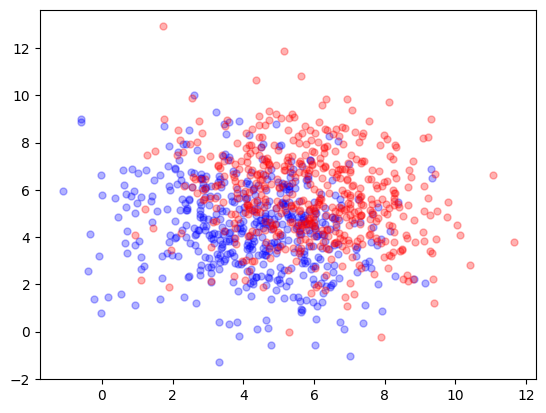

In [25]:

X, y = generate_dataset_4c(n=1000)
plot_data(X, y)

The boundary is linear, but the classes are overlapping and not linearlys separable, so this task is harder than (b)

# C(g)
For a very large dataset, the logistic regression model should converge to the true parameters: w_0 = 10,w_1 = -1,w_2 = -1

In [26]:
# c(h)
model = L2LogisticRegression(C=1e6)  # Large C means no regularization
model.fit(X, y)

# Print the coefficients and intercept
print(f"Coefficients: {model.coefs}")
print(f"Intercept: {model.intercept}")

Coefficients: [-2.03841228e-07 -1.66363990e-07]
Intercept: [-0.02399952]


The coefficients are much smaller than true coefficients, maybe because the optimizer adjusts the intercept to account for the offset in x_1+x_2

# C(i)

In [27]:
# c(i)
# logistic loss
y_proba = model.predict_proba(X)
log_loss = compute_log_loss(y, y_proba)
# AUC
auc = compute_auc(y, y_proba)
# ECE
ece = compute_ece(y, y_proba)

print(f"Logistic Loss: {log_loss}")
print(f"AUC: {auc}")
print(f"ECE: {ece}")

Logistic Loss: 0.6930750404337676
AUC: 0.8163175497271608
ECE: 6.059915014233752e-08


Expected Changes with Larger Dataset:

Training Loss: Should increase slightly and converge to stable average.

AUC: Should improve since a model trained on more data captures the true signal better, even if it still misclassifies.

ECE: Should decrease as the model becomes better calibrated. More data allows the model to learn a better mapping from features to class probabilities.

# c(j)

Penalized logistic regression will not improve prediction accuracy significantly because there’s no multicollinearity, and few features, so not likely to overfitting.

# C(k)
Using basis functions will improve accuracy, because it allows the model to capture nonlinear relationships in the data. Logistic regression's decision boundary is a straight line. But now the true class boundary is nonlinear, the linear model is misspecified.